## 3. Hybrid Quantum-Classical Model

We now build a hybrid model combining a classical neural network with a quantum layer. The classical component uses an LSTM to extract temporal features. The quantum component is a variational quantum circuit (VQC) that acts as a nonlinear transformation layer.

We use the `PennyLane` library to construct the quantum circuit and integrate it with `PyTorch` for training.

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tqdm import tqdm
import pennylane as qml
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchview import draw_graph
from IPython.display import Image, display

import random


In [2]:
# Set the random seed for reproducibility
# This is important for consistent results across runs
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # For GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Make operations deterministic (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(42)

In [3]:

# ✅ List of tickers you want to load
tickers = ["AAPL", "MSFT", "GOOGL"]

# ✅ Dictionary to hold processed DataFrames per ticker
ticker_data = {}

for ticker in tickers:
    print(f"📥 Downloading data for {ticker}...")
    
    df = yf.download(ticker, start="2015-01-01", end="2024-12-31", interval="1d")

    # Flatten MultiIndex if necessary (e.g., from yf multi-ticker download)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Focus on 'Close' prices
    df = df[['Close']].copy()
    df.rename(columns={'Close': 'price'}, inplace=True)

    # Forward-fill missing values
    df.ffill(inplace=True)

    # Normalize prices with individual scalers
    scaler = MinMaxScaler()
    df['normalized'] = scaler.fit_transform(df[['price']])

    # Store
    ticker_data[ticker] = df

print(f"✅ Loaded {len(ticker_data)} tickers.")

📥 Downloading data for AAPL...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


📥 Downloading data for MSFT...


[*********************100%***********************]  1 of 1 completed


📥 Downloading data for GOOGL...


[*********************100%***********************]  1 of 1 completed

✅ Loaded 3 tickers.


**Data Parameters**

In [4]:
# Use a window size (e.g., 20)
WINDOW_SIZE = 20

In [5]:
# To perform time series forecasting, we convert the normalized series into input/output sequences 
# using a sliding window approach.
# [past inputs] → [future targets]
def create_sequences(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

# Initialize holders for aggregated data
X_train_all, y_train_all = [], []
X_test_all, y_test_all = [], []

# Apply to each ticker
for ticker, df in ticker_data.items():
    print(f"🔄 Creating sequences for {ticker}...")
    series = df['normalized'].values
    X, y = create_sequences(series, WINDOW_SIZE)

    # Time-respecting 80/20 split
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Append to global containers
    X_train_all.append(X_train)
    y_train_all.append(y_train)
    X_test_all.append(X_test)
    y_test_all.append(y_test)

    print(f"✅ {ticker}: Train={X_train.shape}, Test={X_test.shape}")

# Combine across all tickers
X_train = np.vstack(X_train_all)
y_train = np.hstack(y_train_all)
X_test = np.vstack(X_test_all)
y_test = np.hstack(y_test_all)

print(f"\n📦 Combined Dataset — Train: {X_train.shape}, Test: {X_test.shape}")


🔄 Creating sequences for AAPL...
✅ AAPL: Train=(1996, 20), Test=(499, 20)
🔄 Creating sequences for MSFT...
✅ MSFT: Train=(1996, 20), Test=(499, 20)
🔄 Creating sequences for GOOGL...
✅ GOOGL: Train=(1996, 20), Test=(499, 20)

📦 Combined Dataset — Train: (5988, 20), Test: (1497, 20)


### 3.1 Quantum Circuit Definition

We define a variational quantum circuit using angle encoding and a simple entangling layer. This circuit will act as a nonlinear layer in the hybrid model.



## Quantum Circuit Hyperparameters

In [6]:
n_qubits = 2 # number of qubits
q_depth  = 2 # number of layers
n_rot_params = 3  # <--- number of rotation parameters per qubit (e.g. 1 for RY, 3 for Rot)

# draw quantum circuit
draw_qc_bool = True

# wether to use quantum or classical model
use_quantum = True

In [7]:
# Device definition
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights, draw=False):
    """
    Variational quantum circuit for hybrid model.
    
    Args:
        inputs (Tensor): Input features (size ≤ n_qubits)
        weights (Tensor): Trainable parameters of shape (q_depth, n_qubits, n_rot_params)
        draw (bool): If True, draw the circuit once (ASCII + matplotlib)
        
    Returns:
        List[Expectation values] for PauliZ on each qubit
    """
    # --- Input Encoding ---
    encoded_inputs = inputs[:n_qubits]
    for i in range(n_qubits):
        qml.RY(encoded_inputs[i], wires=i)
    
    # Optionally, use this instead:
    # qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')

    # --- Variational Layers ---
    for layer in range(q_depth):
        for i in range(n_qubits):
            if n_rot_params == 1:
                qml.RY(weights[layer][i][0], wires=i)
            elif n_rot_params == 2:
                qml.RX(weights[layer][i][0], wires=i)
                qml.RZ(weights[layer][i][1], wires=i)
            elif n_rot_params == 3:
                qml.Rot(*weights[layer][i], wires=i)
            else:
                raise ValueError("n_rot_params must be 1, 2, or 3.")

        # Entanglement (ring topology)
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])

    # --- Optional Drawing ---
    if draw:       
        try:
            fig, ax = qml.draw_mpl(quantum_circuit)(inputs, weights)
            fig.tight_layout()
            fig.show()
        except Exception as e:
            print("⚠️ MPL circuit draw failed:", e)

    # --- Measurement ---
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


C:\Users\npace\AppData\Local\Temp\ipykernel_50376\2088329115.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\npace\AppData\Local\Temp\ipykernel_50376\2088329115.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


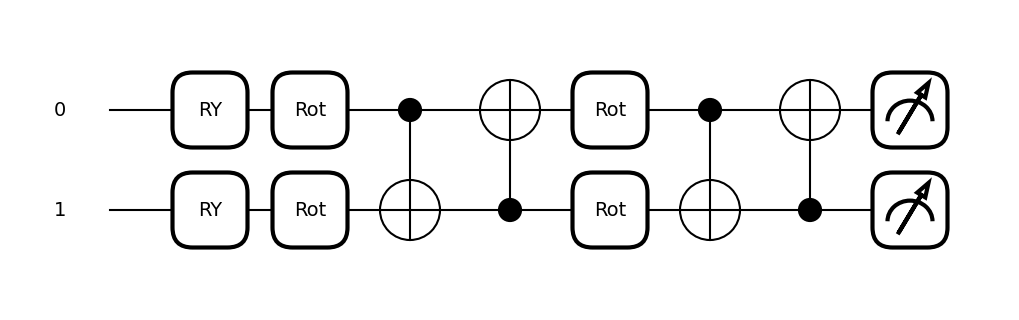

In [8]:
if use_quantum and draw_qc_bool:
    sample_input = torch.randn(n_qubits)
    sample_weights = torch.randn(q_depth, n_qubits, n_rot_params)

    _ = quantum_circuit(sample_input, sample_weights, draw=draw_qc_bool)


In [9]:
class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, q_depth, n_rot_params):
        super().__init__()

        # Initialize trainable parameters for the quantum circuit
        # Shape: [q_depth, n_qubits, n_rot_params] (rotation angles per qubit per layer)
        q_init = torch.empty(q_depth, n_qubits, n_rot_params)
        torch.nn.init.normal_(q_init, mean=0.0, std=0.01)  # Small init to avoid flat gradients
        self.q_params = nn.Parameter(q_init)

        self.n_qubits = n_qubits
        self.q_depth = q_depth
        self.n_rot_params = n_rot_params

    def forward(self, x_batch):
        """
        Apply the quantum circuit to each sample in the batch.

        Args:
            x_batch (Tensor): Input of shape [batch_size, n_qubits]

        Returns:
            Tensor: Output of shape [batch_size, n_qubits]
        """
        outputs = []
        for x in x_batch:
            # Apply the quantum circuit to each sample
            q_out = quantum_circuit(x, self.q_params)

            # Convert list of expectation values into a float32 tensor
            q_tensor = torch.stack(q_out).to(dtype=torch.float32)

            outputs.append(q_tensor)

        # Stack the results into a batch tensor
        return torch.stack(outputs)


**Dummy Class for visualizing the Quantum Layer**

In [10]:
class VisualQuantumLayer(nn.Module):
    def __init__(self, out_features, in_features=None, label="QuantumLayer", n_qubits=2, q_depth=1, n_rot_params=3):
        super().__init__()
        self.out_features = out_features
        self.in_features = in_features or out_features

        # 🧠 Add these to match real QuantumLayer
        self.n_qubits = n_qubits
        self.q_depth = q_depth
        self.n_rot_params = n_rot_params

        self.dummy = nn.Linear(self.in_features, self.out_features, bias=False)
        for param in self.dummy.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.dummy(x)


In [11]:
class HybridQNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 n_qubits=4, q_depth=1, n_rot_params=3, ML_unit_type = 'LSTM', num_ML_layers = 1, use_quantum=True,
                 post_quantum_activation=None, skip_connection="concat",output_activation="Sigmoid",
                 use_dropout=False, dropout_rate=0.3,
                 use_layernorm=False):
        super().__init__()
        
        self.use_quantum = use_quantum
        self.post_quantum_activation = post_quantum_activation  # 👈 Store this
        self.skip_connection = skip_connection  # 👈 Store this
        self.n_qubits = n_qubits  # 👈 Store this
        self.use_dropout = use_dropout
        self.dropout_rate = dropout_rate
        self.use_layernorm = use_layernorm



        ML_unit_type = ML_unit_type.upper()
        # ✅ Check that it's at least valid before trying to build
        if not any(unit in ML_unit_type for unit in ["LSTM", "GRU", "RNN"]):
            raise ValueError(f"Unsupported ML unit type: {ML_unit_type}. Supported types: LSTM, GRU, RNN")

        # Build stack
        self.sequence_stack = nn.Sequential()

        if "LSTM" in ML_unit_type:
            self.sequence_stack.add_module("lstm", nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                                        num_layers=num_ML_layers, batch_first=True))

        if "GRU" in ML_unit_type:
            self.sequence_stack.add_module("gru", nn.GRU(input_size=hidden_size, hidden_size=hidden_size,
                                                        num_layers=1, batch_first=True))
        if "RNN" in ML_unit_type:
            self.sequence_stack.add_module("rnn", nn.RNN(input_size=hidden_size, hidden_size=hidden_size,
                                                        num_layers=1, batch_first=True))

        # Linear layer to map LSTM output to quantum layer input size
        self.linear1 = nn.Linear(hidden_size, n_qubits)

        # Optional quantum layer for variational feature extraction
        if use_quantum:
            if torch.jit.is_scripting() or torch.jit.is_tracing():
                # Use dummy version during tracing
                self.quantum = VisualQuantumLayer(n_qubits)
            else:
                self.quantum = QuantumLayer(n_qubits=n_qubits, q_depth=q_depth, n_rot_params=n_rot_params)

        if self.use_layernorm:
            self.layernorm = nn.LayerNorm(n_qubits)

        if self.use_dropout:
            self.dropout = nn.Dropout(p=self.dropout_rate)
    
        # ⬇ decide how many features go into final layer
        if skip_connection == "concat":
            in_features = 2 * n_qubits
        else:
            in_features = n_qubits

        # Final linear layer
        self.linear2 = nn.Linear(in_features, output_size)

        # Final activation function for output layer
        # to any of the supported activation functions
        if output_activation == "ReLU":
            self.output_activation = nn.ReLU()
        elif output_activation == "Tanh":
            self.output_activation = nn.Tanh()
        elif output_activation == "Sigmoid":
            self.output_activation = nn.Sigmoid()
        elif output_activation == "Softmax":
            self.output_activation = nn.Softmax(dim=1)
        else:
            self.output_activation = None
            
        self.output_activation_name = output_activation  # ← This keeps the original string

           
    def forward(self, x):
        # Input shape check: should be (batch_size, sequence_length, input_size)
        if len(x.shape) != 3:
            raise ValueError(f"Expected input shape (batch_size, seq_len, input_size), got {x.shape}")

        # Run input through sequence stack (LSTM/GRU/RNN)
        rnn_out = x
        for layer in self.sequence_stack:
            if isinstance(layer, (nn.LSTM, nn.GRU, nn.RNN)):
                rnn_out, _ = layer(rnn_out)
            else:
                rnn_out = layer(rnn_out)


        # Use the final hidden state of the sequence
        last_hidden = rnn_out[:, -1, :]

        # Project to quantum input dimension
        reduced = self.linear1(last_hidden)

        # Apply quantum layer if enabled
        if self.use_quantum:
            quantum_out = self.quantum(reduced)
            
            if self.post_quantum_activation == "ReLU":
                quantum_out = torch.relu(quantum_out)
                
            elif self.post_quantum_activation == "Tanh":
                quantum_out = torch.tanh(quantum_out)
                
            elif self.post_quantum_activation == "Sigmoid":
                quantum_out = torch.sigmoid(quantum_out)
        
        else:
            quantum_out = reduced  # fallback to classical-only path
            
        # ✅ Optional regularization after quantum
        if self.use_layernorm:
            quantum_out = self.layernorm(quantum_out)

        if self.use_dropout:
            quantum_out = self.dropout(quantum_out)


        # Concatenate classical and quantum outputs
        if self.skip_connection == "add":
            x_out = quantum_out + reduced
        elif self.skip_connection == "concat":
            x_out = torch.cat([quantum_out, reduced], dim=1)
        else:
            x_out = quantum_out  # quantum-only path

        

        # Final linear projection
        out = self.linear2(x_out)

        return self.output_activation(out) if self.output_activation else out



## 4. Training the Hybrid Quantum-Classical Model

In this section, we convert our data to PyTorch tensors, define a loss function and optimizer, and train the hybrid model over multiple epochs. The model will learn to predict the next price value based on prior values in the sequence.


In [12]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # Shape: (batch, seq, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Model Hyperparameters ##

In [13]:
experiment_notes = "run with Quantum layer"

# === Model Config ===
# Set model hyperparameters
input_size = 1
hidden_size = 16
output_size = 1

# draw the QML or ML model graph
draw_model_graph = True

learning_rate = 0.001

num_epochs = 15
use_dropout=False
dropout_rate= 0.0 # 0.2 to 0.5 is common for LSTM/GRU
use_layernorm=False 

# === Early Stopping Config ===
early_stop_patience = 2 # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0

# TODO add ARIMA, xLSTM, and transformers options
ML_unit_type = "LSTM"  # "LSTM", "GRU", or "RNN" can havy many layers
num_ML_layers = 4  # Number of LSTM/GRU/RNN layers

post_quantum_activation = None  # "ReLU", "Tanh", "Sigmoid", or None
skip_connection = "concat"  # "concat" or "add"
output_activation = None # "ReLU", "Tanh", "Sigmoid", "Softmax", or None


In [14]:

# Set the sequence length based on the training data
sequence_length = X_train.shape[1]

# Instantiate the model 
# (use_quantum=True for quantum model, False for classical model)
model = HybridQNN(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    n_qubits=n_qubits,
    q_depth=q_depth,
    n_rot_params=n_rot_params,
    ML_unit_type=ML_unit_type,
    num_ML_layers=num_ML_layers,
    use_quantum=use_quantum,  # Set to True for quantum model
    post_quantum_activation=post_quantum_activation,
    skip_connection=skip_connection,
    output_activation=output_activation,
    use_dropout=use_dropout,
    dropout_rate=dropout_rate,
    use_layernorm=use_layernorm
)

#use GPU if available **TODO**
    
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


### Visualize the Model

ex..
(LSTM → Linear → Quantum → Merge → Output)


(process:50116): Pango-WARNING **: 17:30:53.481: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


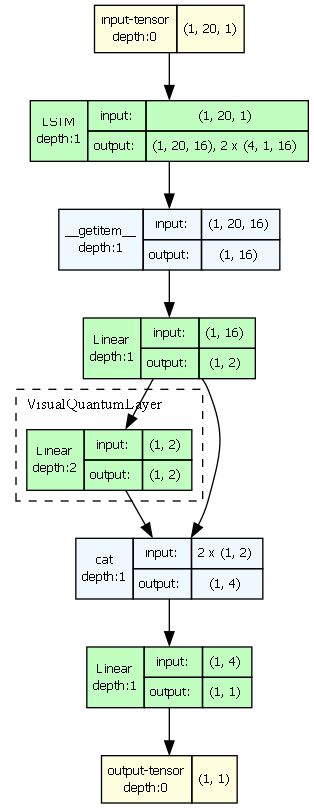

In [15]:
if draw_model_graph:
    # 🔁 If model is using quantum, swap in visual quantum layer
    if model.use_quantum:
        model.quantum = VisualQuantumLayer(
            out_features=n_qubits,
            in_features=n_qubits,
            n_qubits=n_qubits,
            q_depth=q_depth,
            n_rot_params=n_rot_params
        )

    # 🧠 Label the graph meaningfully
    graph_name = f"Hybrid QNN ({'With' if model.use_quantum else 'Without'} Quantum Layer)"

    # 🎨 Draw the full model architecture
    viz_model = draw_graph(
        model,
        input_size=(1, sequence_length, input_size),
        expand_nested=True,
        graph_name=graph_name,
        roll=True,
        save_graph=False
    )

    # 🖼️ Render directly in notebook
    png_bytes = viz_model.visual_graph.pipe(format="png")
    display(Image(data=png_bytes))


### 🔁 4.1 Training Loop

We train the model for a number of epochs using Mean Squared Error (MSE) loss. During each epoch, we record the training loss to monitor convergence.


In [16]:
# Training loop
# Use tqdm for progress bar in each epoch
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Use tqdm for progress bar in each epoch
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for X_batch, y_batch in train_loader_tqdm:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # === Validation ===
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f"📘 Epoch {epoch+1:3d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # === Early Stopping Check ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Optional: save model checkpoint
        torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_no_improve += 1
        print(f"⚠️  No improvement for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= early_stop_patience:
        print("⛔ Early stopping triggered.")
        break


📘 Epoch   1 | Train Loss: 0.023468 | Val Loss: 0.028991


📘 Epoch   2 | Train Loss: 0.000569 | Val Loss: 0.007592


📘 Epoch   3 | Train Loss: 0.000522 | Val Loss: 0.012296
⚠️  No improvement for 1 epoch(s)


📘 Epoch   4 | Train Loss: 0.000445 | Val Loss: 0.004176


📘 Epoch   5 | Train Loss: 0.000483 | Val Loss: 0.003920


📘 Epoch   6 | Train Loss: 0.000425 | Val Loss: 0.003426


📘 Epoch   7 | Train Loss: 0.000376 | Val Loss: 0.006550
⚠️  No improvement for 1 epoch(s)


📘 Epoch   8 | Train Loss: 0.000395 | Val Loss: 0.002242


📘 Epoch   9 | Train Loss: 0.000409 | Val Loss: 0.002395
⚠️  No improvement for 1 epoch(s)


📘 Epoch  10 | Train Loss: 0.000311 | Val Loss: 0.001854


📘 Epoch  11 | Train Loss: 0.000314 | Val Loss: 0.000972


📘 Epoch  12 | Train Loss: 0.000291 | Val Loss: 0.000901


📘 Epoch  13 | Train Loss: 0.000249 | Val Loss: 0.000741


📘 Epoch  14 | Train Loss: 0.000275 | Val Loss: 0.000723


📘 Epoch  15 | Train Loss: 0.000262 | Val Loss: 0.000859
⚠️  No improvement for 1 epoch(s)


📈 Plot Training Loss
Code Cell:

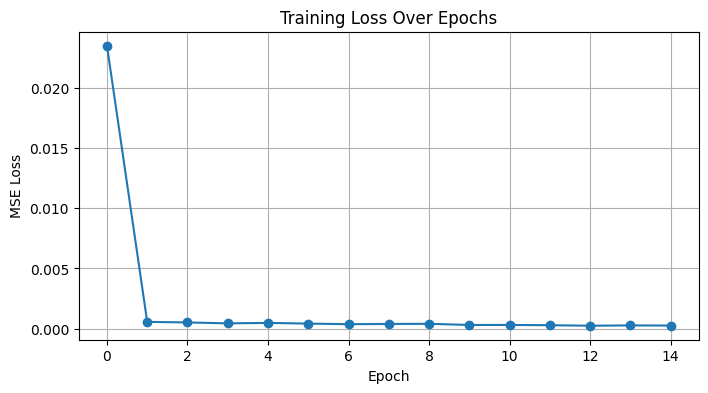

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


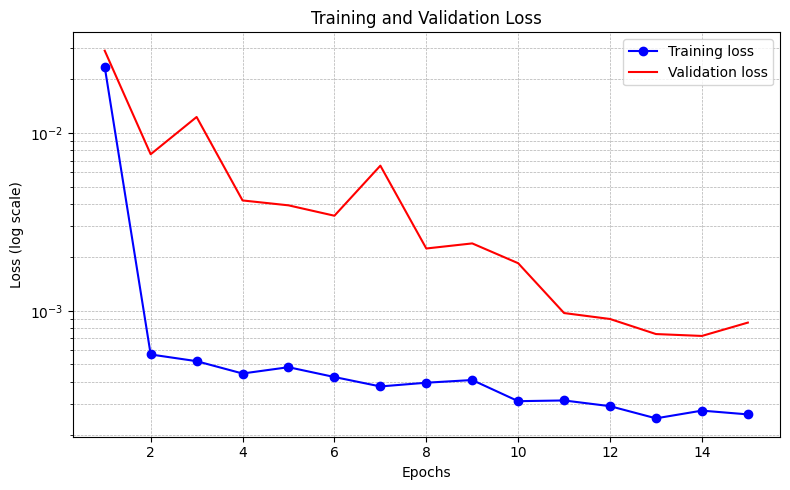

In [18]:

epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'r-', label='Validation loss')
plt.yscale('log')  # Log scale for better visibility of trends
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## 5. Evaluation and Prediction

Now that the hybrid model has been trained, we evaluate its performance on the test set and visualize the predicted vs actual values. This helps us assess how well the model generalizes to unseen data.


✅ Loaded best model from checkpoint for final evaluation.


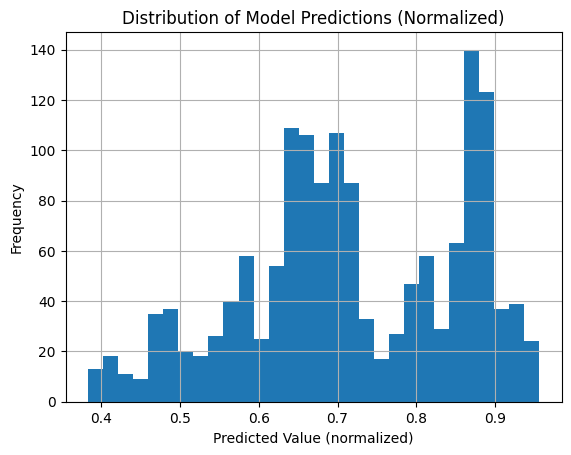

In [19]:
# === Load the best model for testing/prediction ===
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
print("✅ Loaded best model from checkpoint for final evaluation.")

predictions = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        y_pred = model(X_batch)
        predictions.append(y_pred.detach().cpu())

# Concatenate and flatten
predictions = torch.cat(predictions).squeeze().numpy()
y_true = y_test_tensor.squeeze().cpu().numpy()

# Now plot the distribution
plt.hist(predictions, bins=30)
plt.title("Distribution of Model Predictions (Normalized)")
plt.xlabel("Predicted Value (normalized)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


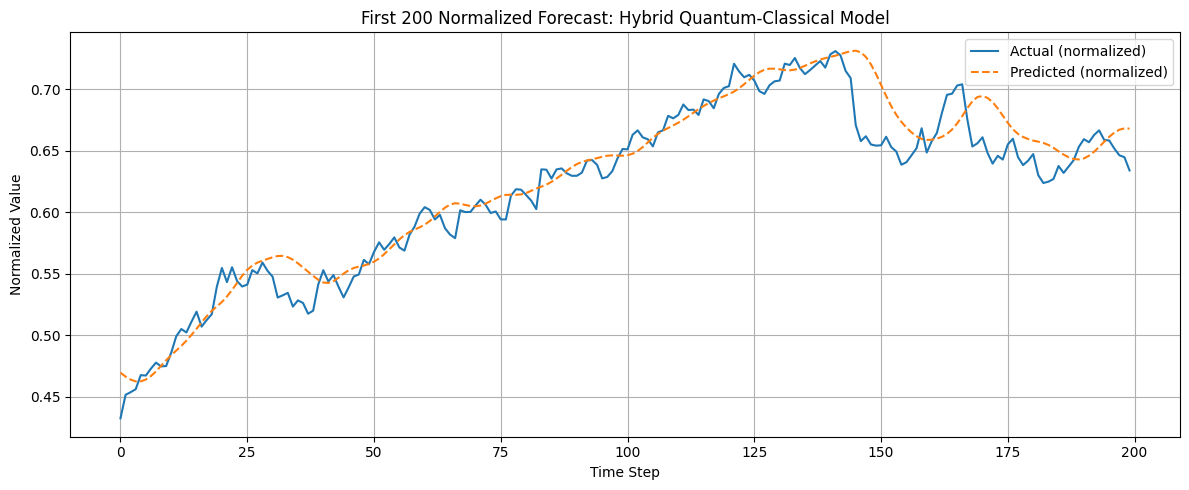

In [20]:
plt.figure(figsize=(12, 5))
plt.plot(y_true[:200], label="Actual (normalized)")
plt.plot(predictions[:200], label="Predicted (normalized)", linestyle='--')
if use_quantum:
    plt.title("First 200 Normalized Forecast: Hybrid Quantum-Classical Model")
else:
    plt.title("First 200 Normalized Forecast: Classical Model")
plt.xlabel("Time Step")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
print("Scaler data min:", scaler.data_min_)
print("Scaler data max:", scaler.data_max_)

Scaler data min: [24.73474693]
Scaler data max: [196.43377686]


**🔄 Inverse Transform (Denormalize)**

In [22]:
# Reshape for inverse_transform (must be 2D)
predicted_prices = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
true_prices = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

### 5.1 Plot Forecasted vs Actual Prices
We now visualize how well the model’s predictions match the ground truth prices over time.


In [23]:
# Create storage dict
ticker_sequences = {}

# Index tracking for slicing predictions back per ticker
test_start = 0

for ticker, df in ticker_data.items():
    print(f"📤 Collecting results for {ticker}...")

    # Recreate y_test length for this ticker
    series = df['normalized'].values
    X_all, y_all = create_sequences(series, WINDOW_SIZE)
    split_index = int(len(X_all) * 0.8)
    y_test_len = len(y_all[split_index:])

    # Slice predictions and ground truth
    ticker_pred = predicted_prices[test_start:test_start + y_test_len]
    ticker_true = true_prices[test_start:test_start + y_test_len]

    # Save to dictionary
    ticker_sequences[ticker] = {
        "predicted_prices": ticker_pred,
        "true_prices": ticker_true,
        "dates": df.index[-y_test_len:]  # Match test dates
    }

    test_start += y_test_len


📤 Collecting results for AAPL...
📤 Collecting results for MSFT...
📤 Collecting results for GOOGL...


📊 Plotting forecast for AAPL...


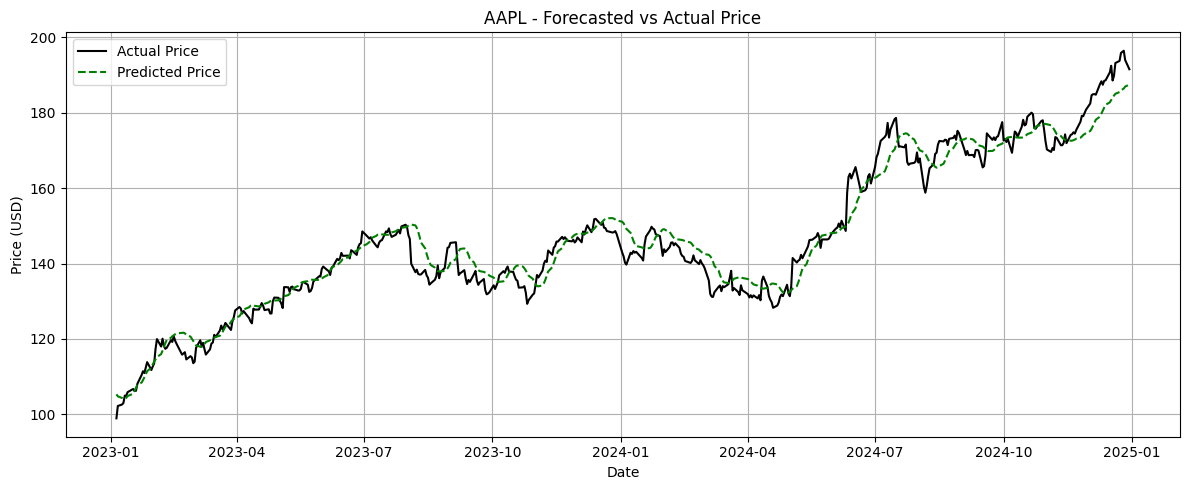

📊 Plotting forecast for MSFT...


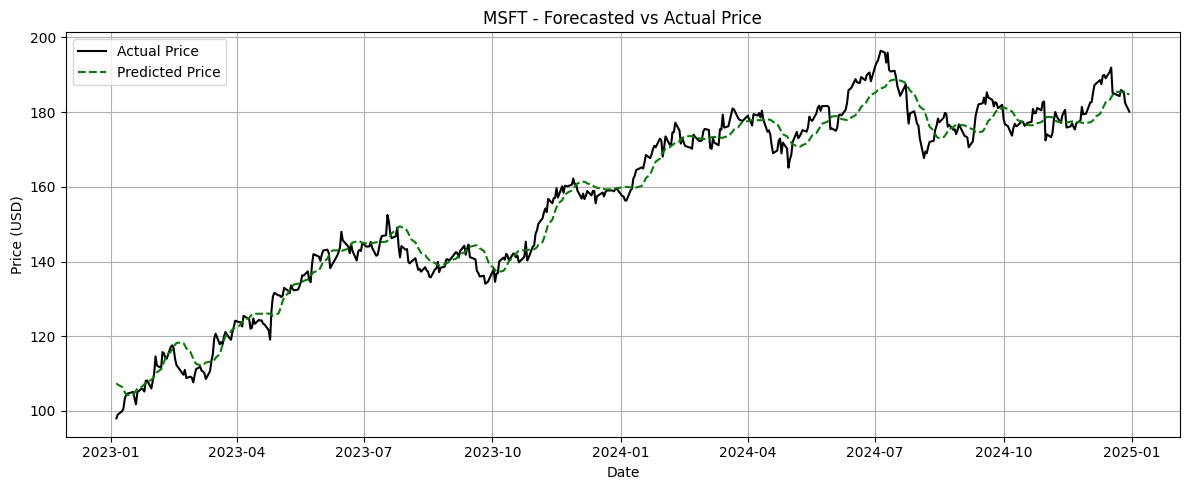

📊 Plotting forecast for GOOGL...


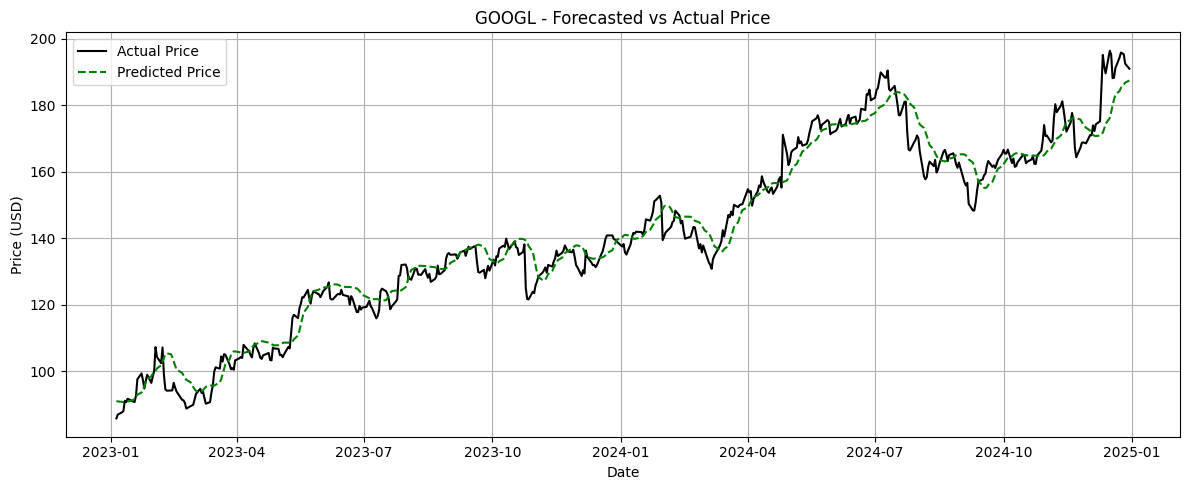

In [24]:
for ticker, results in ticker_sequences.items():
    print(f"📊 Plotting forecast for {ticker}...")

    plt.figure(figsize=(12, 5))
    plt.plot(results["dates"], results["true_prices"], label='Actual Price', color='black')
    plt.plot(results["dates"], results["predicted_prices"], label='Predicted Price', linestyle='--', color='green')
    plt.title(f"{ticker} - Forecasted vs Actual Price")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### 5.2 Evaluation Metrics

We compute standard forecasting error metrics to quantify model performance.


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(true_prices, predicted_prices)
rmse = mean_squared_error(true_prices, predicted_prices, squared=False)

print(f"📈 Test MAE  = {mae:.4f}")
print(f"📈 Test RMSE = {rmse:.4f}")


📈 Test MAE  = 3.5201
📈 Test RMSE = 4.5696


c:\Users\npace\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


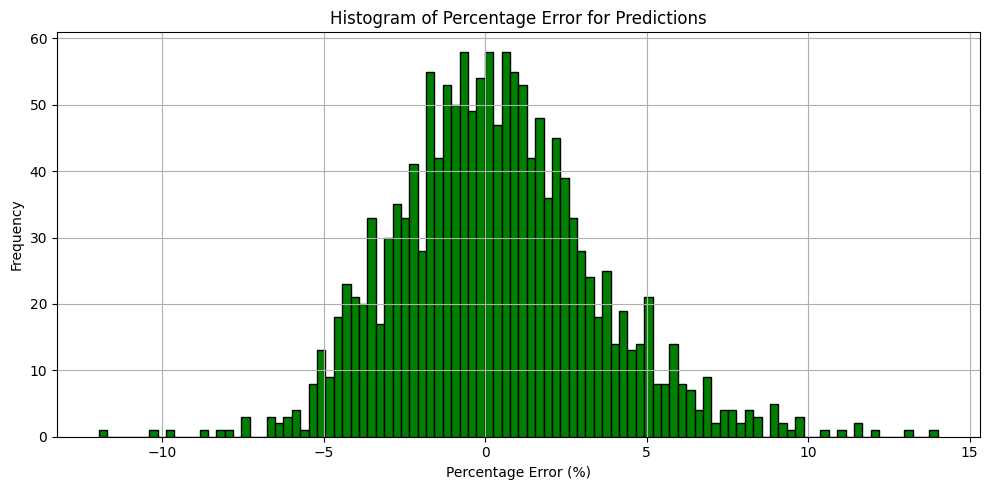

In [26]:
# Compute percentage errors
percentage_errors = 100 * (predicted_prices - true_prices) / true_prices

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(percentage_errors, bins=100, color='green', edgecolor='black')
plt.title("Histogram of Percentage Error for Predictions")
plt.xlabel("Percentage Error (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
avg_percent_error = np.mean(np.abs(percentage_errors))
print(f"Average Absolute Percentage Error: {avg_percent_error:.2f}%")

Average Absolute Percentage Error: 2.41%


### 📊 Logging Expiremental Results to Excel 

In [28]:
def log_experiment(model, window_size, num_epochs, patience,
                   avg_train_loss, avg_val_loss, mae, rmse,
                   avg_percent_error, tickers, notes=""):

    # --- Extract model config ---
    use_quantum = getattr(model, "use_quantum", False)
    post_quantum_activation = getattr(model, "post_quantum_activation", None)
    skip_connection = getattr(model, "skip_connection", None)
    final_activation = getattr(model, "output_activation_name", None)
    use_dropout = getattr(model, "use_dropout", False)
    dropout_rate = getattr(model, "dropout_rate", None)
    use_layernorm = getattr(model, "use_layernorm", False)

    # --- Sequence architecture inspection ---
    lstm_layers = 0
    gru_layers = 0
    rnn_layers = 0
    hidden_size = None

    for module in model.sequence_stack:
        if isinstance(module, nn.LSTM):
            lstm_layers += module.num_layers
            hidden_size = module.hidden_size
        elif isinstance(module, nn.GRU):
            gru_layers += module.num_layers
            hidden_size = module.hidden_size
        elif isinstance(module, nn.RNN):
            rnn_layers += module.num_layers
            hidden_size = module.hidden_size

    # --- Quantum circuit info (if used) ---
    if use_quantum and hasattr(model, "quantum"):
        n_qubits = getattr(model.quantum, "n_qubits", "-")
        q_depth = getattr(model.quantum, "q_depth", "-")
        n_rot_params = getattr(model.quantum, "n_rot_params", "-")
    else:
        n_qubits, q_depth, n_rot_params = "-", "-", "-"

    # --- Load or initialize Excel sheet ---
    try:
        df = pd.read_excel("qml_experiment_log.xlsx")
        next_id = int(df["Experiment ID"].max()) + 1
    except (FileNotFoundError, ValueError, KeyError):
        df = pd.DataFrame()
        next_id = 1

    # --- Assemble experiment entry ---
    new_result = {
        # 🧾 Metadata
        "Experiment ID": next_id,
        "Tickers": ", ".join(tickers),
        "Description": f"Auto-log: Q={n_qubits}, D={q_depth}, Skip={skip_connection}",

        # 🧠 Classical architecture
        "LSTM Layers": lstm_layers,
        "GRU Layers": gru_layers,
        "RNN Layers": rnn_layers,
        "Hidden Size": hidden_size,
        "Window Size": window_size,

        # ⚛️ Quantum architecture
        "Use Quantum": use_quantum,
        "Qubits": n_qubits,
        "Q Depth": q_depth,
        "Rotation Params": n_rot_params,
        "Skip Connection": skip_connection,
        "Post-Quantum Activation": post_quantum_activation,

        # 🎛️ Regularization & Activation
        "Use Dropout": use_dropout,
        "Dropout Rate": dropout_rate,
        "Use LayerNorm": use_layernorm,
        "Final Activation": final_activation,

        # 🏋️ Training setup
        "Num Epochs": num_epochs,
        "Early Stop Patience": patience,

        # 📈 Results
        "Train Loss": avg_train_loss,
        "Validation Loss": avg_val_loss,
        "MAE": mae,
        "RMSE": rmse,
        "Avg % Error": avg_percent_error,

        # 🗒️ Notes
        "Notes": notes
    }

    # --- Append and save ---
    df = pd.concat([df, pd.DataFrame([new_result])], ignore_index=True)
    df.to_excel("qml_experiment_log.xlsx", index=False)
    print(f"📋 Experiment logged as ID {next_id}")


In [29]:
log_experiment(
    model=model,
    window_size=WINDOW_SIZE,
    num_epochs=num_epochs,
    patience=early_stop_patience,
    avg_train_loss=avg_train_loss,
    avg_val_loss=avg_val_loss,
    mae=mae,
    rmse=rmse,
    avg_percent_error=avg_percent_error,
    tickers=tickers,
    notes=experiment_notes
)


📋 Experiment logged as ID 19
